# Q1

## Part a

In [25]:
import pandas as pd
import numpy as np
import scipy.io as sio
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
import random
import scipy as sp

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from skimage import color
from skimage import io

In [26]:
# Loading data and extracting the images
data = sio.loadmat('data/isomap.mat')
images = data['images']
images = images.T

In [27]:
# Calculating the Euclidean distances
distances = pairwise_distances(images,metric='euclidean')

In [28]:
neighbors = np.zeros_like(distances)

# Taking the nearest 100 neighbours
sort_distances = np.argsort(distances, axis=1)[:, 1:101]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

maxDist = np.max(neighbors)
# Put a very high distance for anything higher than the max distance in the 100 nearest neighbours
neighbors[neighbors>maxDist] = 5000

In [29]:
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, \\
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.

    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    np.savetxt('D.csv', D)
    return D


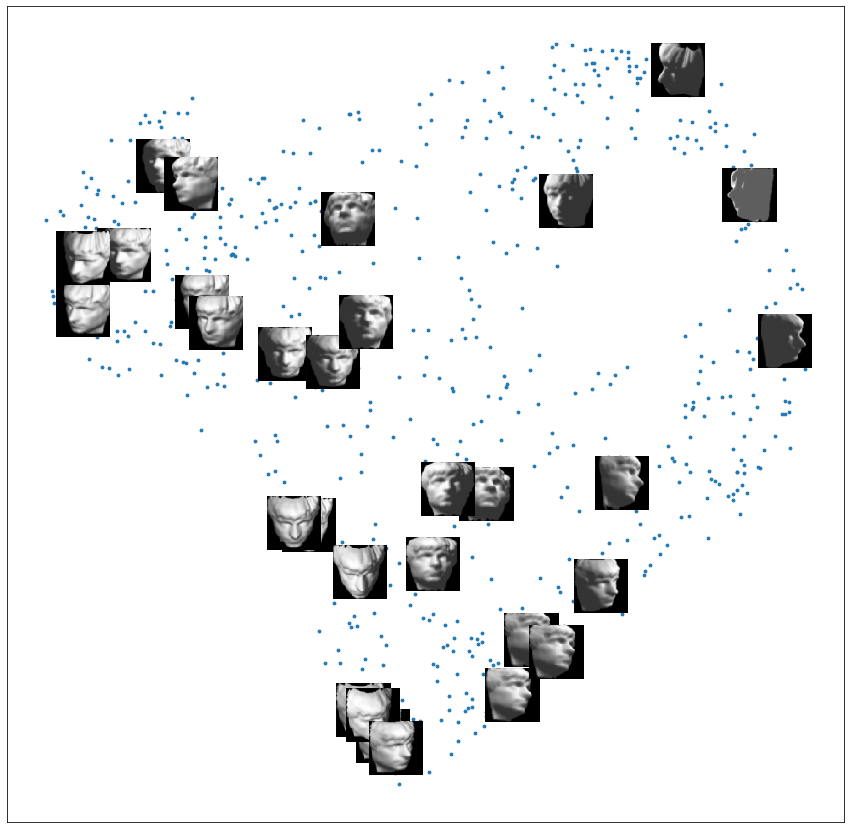

In [30]:
# Drawing the graph
plt.figure(figsize=(15,15))
g = nx.Graph(neighbors)
a = nx.adjacency_matrix(g)
pos = nx.spring_layout(g) 
nx.draw_networkx_nodes(g,pos,node_size=8)

# Plot 30 images, randomly selected
rand = random.sample(range(len(g.nodes())), 30)
ax = plt.gca()
fig = plt.gcf()
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05
# fig.set_size_inches(18.5, 10.5)

for n in g.nodes():      
    if n in rand:
        (x,y) = pos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
        W = images[n].reshape((64,64),order='F')
        a.imshow(W, cmap='gray')
        a.set_aspect('equal')
        a.axis('off')

## Part b

In [31]:
# From lectures, we build the Isomap algorithm
D = Matrix_D(distances)
m = len(images)
I = np.identity(m)
one = np.ones((m,1))
H = I - 1/m * one @ one.T
C = (-1/(2*D.shape[0])) * (H @ D*D @ H)

In [32]:
C

array([[-0.02110335, -0.02278371,  0.03418945, ..., -0.04899189,
        -0.02956176,  0.00265814],
       [-0.02372021, -0.01218492, -0.03127573, ...,  0.03777913,
        -0.00225184, -0.02869185],
       [ 0.03763776, -0.02847921, -0.01662002, ..., -0.06762477,
        -0.03269466, -0.00067771],
       ...,
       [-0.03531035,  0.05838791, -0.05654315, ...,  0.01916842,
         0.00141966,  0.05218125],
       [-0.0308357 ,  0.00244683, -0.03626288, ..., -0.01295383,
         0.04781434,  0.04143772],
       [ 0.00784588, -0.02544352,  0.00201284, ...,  0.03949665,
         0.03716536,  0.00862598]])

In [33]:
# Finding the leading eigenvalues and eigenvectors
eigval, eigvec = np.linalg.eigh(C)

top2val= eigval[-2:]
top2vec = eigvec[:,-2:]

In [34]:
valueDiag = np.diag((top2val)**-.5)
vector2 = top2vec

# Finding the Z matrix
Z =  vector2 @ valueDiag

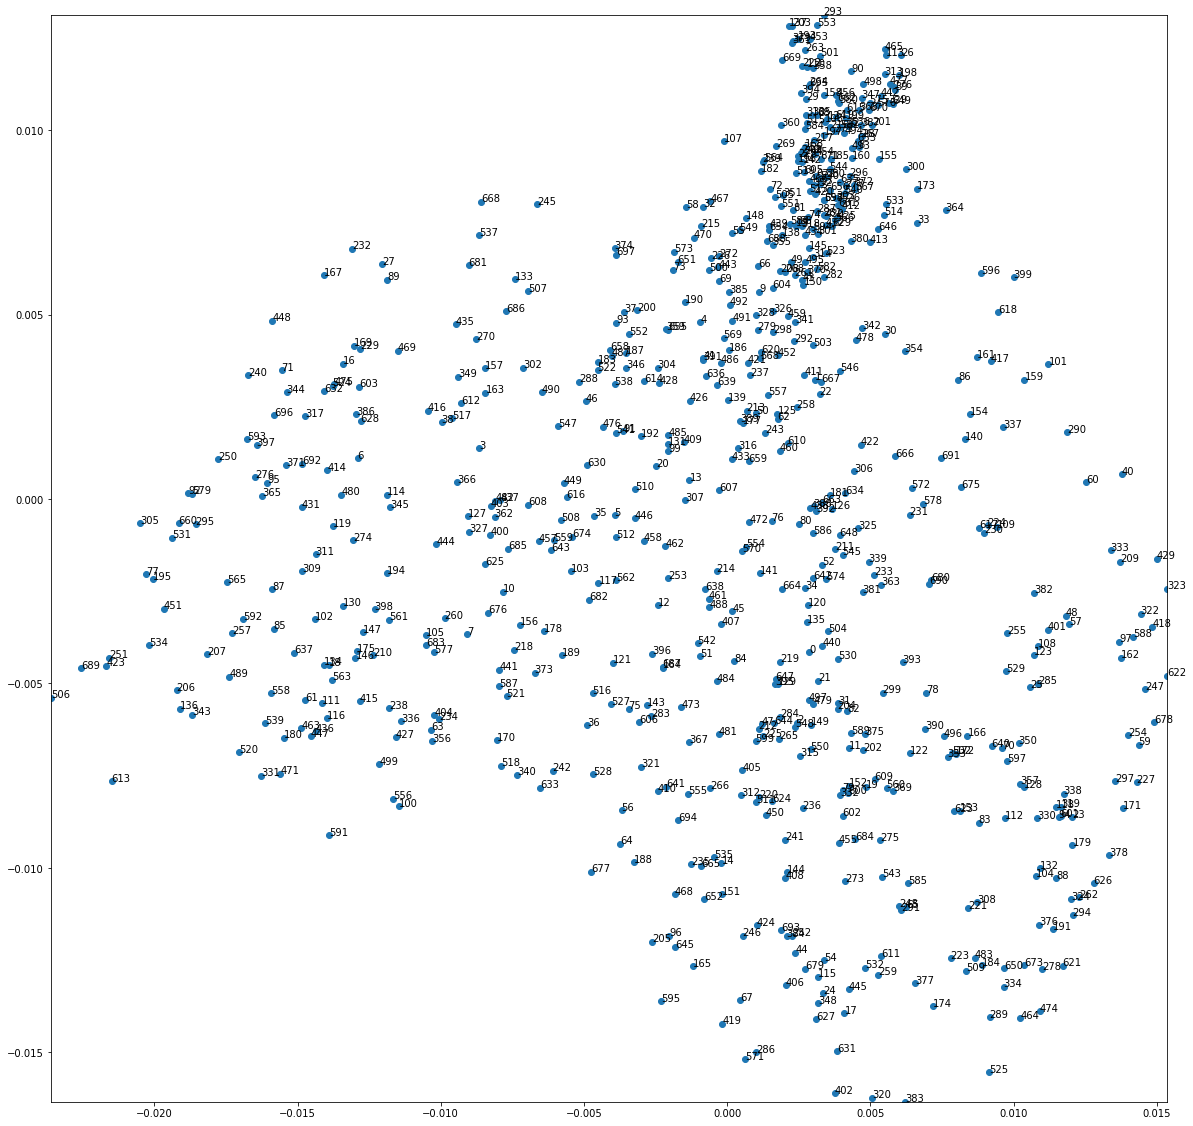

In [35]:
# Plotting the embeddings
label = range(len(images))
fig, ax = plt.subplots(figsize=(20,20))
plt.xlim([min(Z[:,0]),max(Z[:,0])])
plt.ylim([min(Z[:,1]),max(Z[:,1])])
plt.scatter(Z[:,0],Z[:,1])

for i, txt in enumerate(label):
    plt.annotate(txt, (Z[i,0],Z[i,1]))

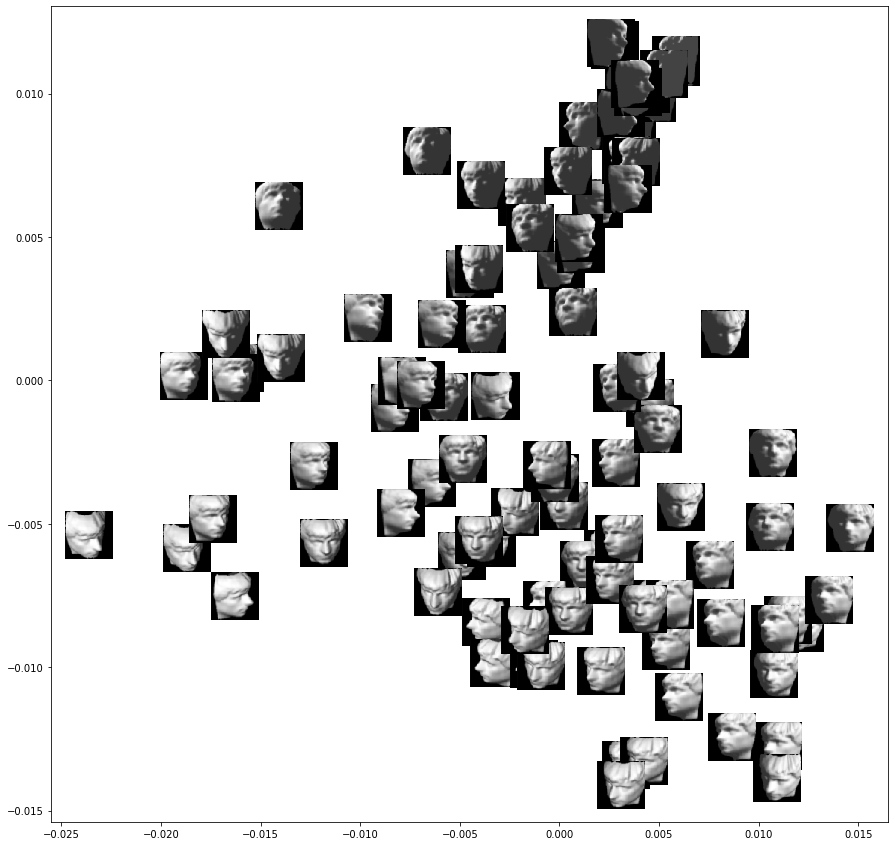

In [40]:
# Referenced from 
# https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points/53851017
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom,cmap='gray')
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots(figsize=(15,15))
rand = random.sample(range(len(images)), 100)
for i in range(len(images)):
    if i in rand:
        x =Z[i,0]
        y =Z[i,1]
        W = images[i].reshape((64,64),order='F')
        imscatter(x,y, W, zoom=0.75, ax=ax)
        ax.plot(x,y)

plt.show()

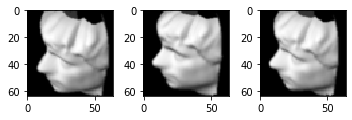

In [43]:
# We pick 3 points that are close
W1 = images[64].reshape((64,64),order='F')
W2 = images[188].reshape((64,64),order='F')
W3 = images[677].reshape((64,64),order='F')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].imshow(W1, cmap='gray')
axes[1].imshow(W2, cmap='gray')
axes[2].imshow(W3, cmap='gray')
fig.tight_layout()


## Part c

In [44]:
manhattanDistances = pairwise_distances(images,metric='manhattan')

In [45]:
manhattanneighbors = np.zeros_like(manhattanDistances)
sort_manhattandistances = np.argsort(manhattanDistances, axis=1)[:, 1:101]
for k,i in enumerate(sort_manhattandistances):
    manhattanneighbors[k,i] = manhattanDistances[k,i]


maxDist = np.max(manhattanneighbors)

manhattanneighbors[manhattanneighbors>maxDist] = 5000

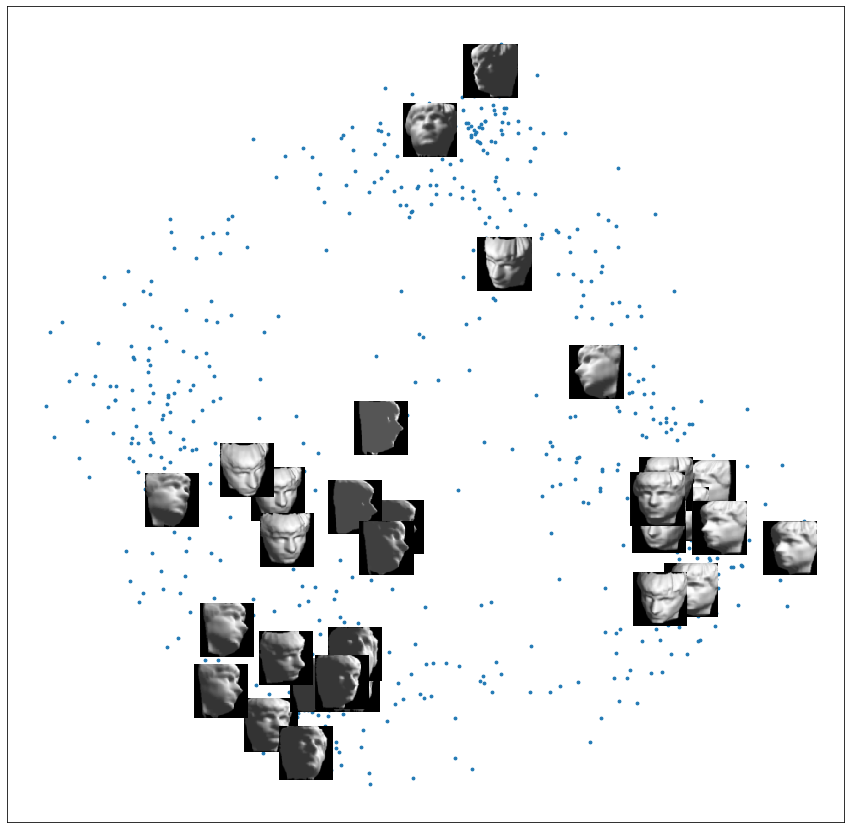

In [46]:
# Drawing the graph
plt.figure(figsize=(15,15))
g = nx.Graph(manhattanneighbors)
a = nx.adjacency_matrix(g)
pos = nx.spring_layout(g) 
nx.draw_networkx_nodes(g,pos,node_size=8)

# Plot 30 images, randomly selected
rand = random.sample(range(len(g.nodes())), 30)
ax = plt.gca()
fig = plt.gcf()
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05

for n in g.nodes():         
    if n in rand:
        (x,y) = pos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
        W = images[n].reshape((64,64),order='F')
        a.imshow(W,cmap='gray')
        a.set_aspect('equal')
        a.axis('off')

In [47]:
# Running the algorithm on the Manhattan distances
D = Matrix_D(manhattanDistances)
m = len(images)
I = np.identity(m)
one = np.ones((m,1))
H = I - 1/m * one @ one.T
C=(-1/(2*D.shape[0])) * (H @ D*D @ H)

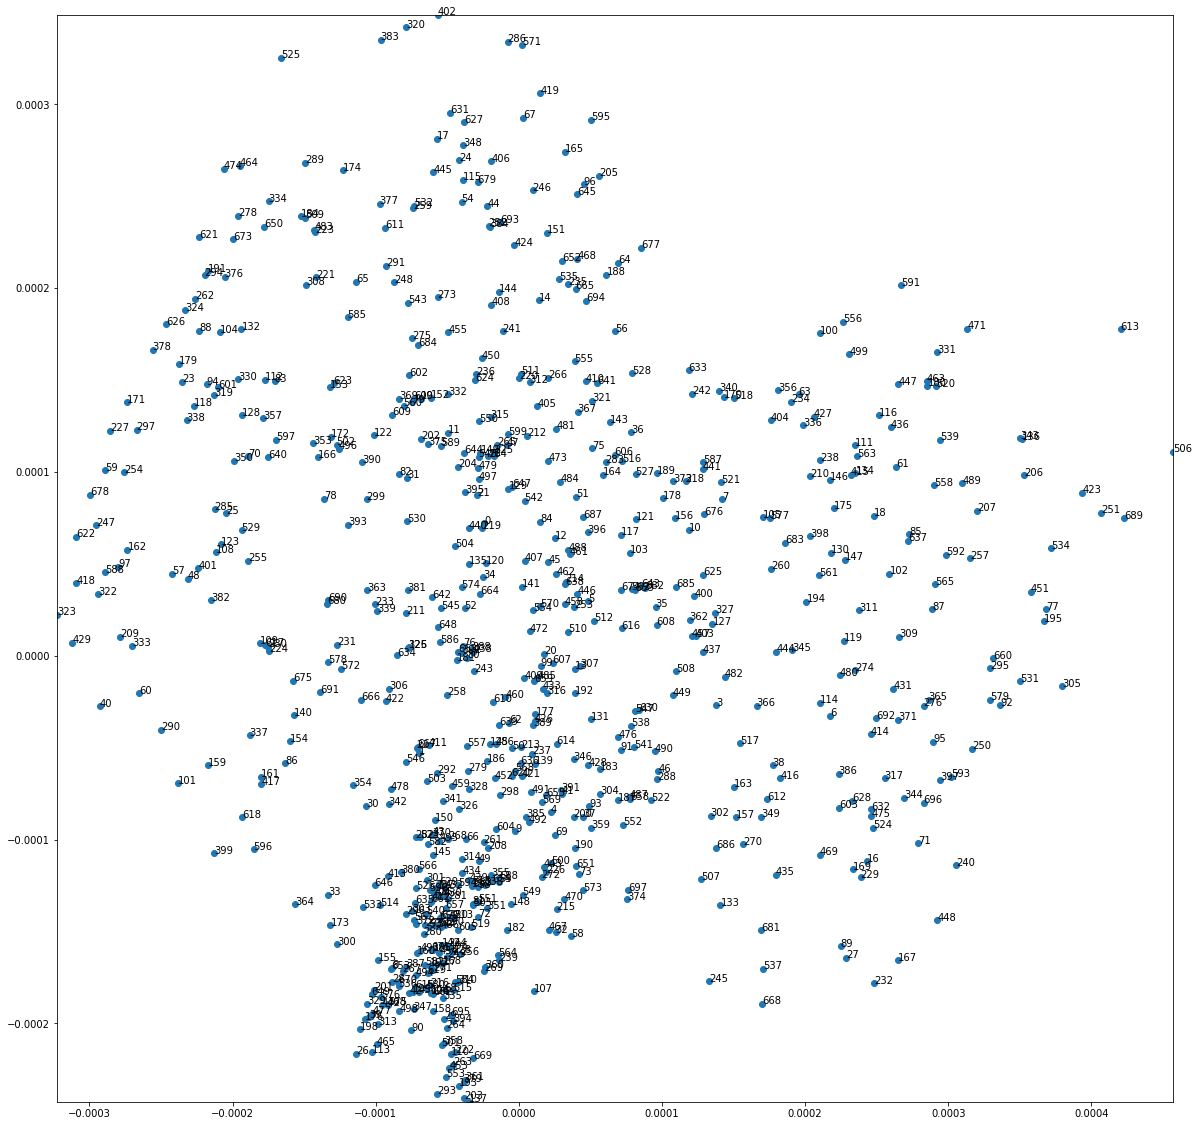

In [48]:
eigval, eigvec = np.linalg.eigh(C)

top2val= eigval[-2:]
top2vec = eigvec[:,-2:]

valueDiag = np.diag((top2val)**-.5)
vector2 = top2vec

Z =  vector2 @ valueDiag

label = range(len(images))
fig, ax = plt.subplots(figsize=(20,20))
plt.xlim([min(Z[:,0]),max(Z[:,0])])
plt.ylim([min(Z[:,1]),max(Z[:,1])])

plt.scatter(Z[:,0],Z[:,1])

for i, txt in enumerate(label):
    plt.annotate(txt, (Z[i,0],Z[i,1]))

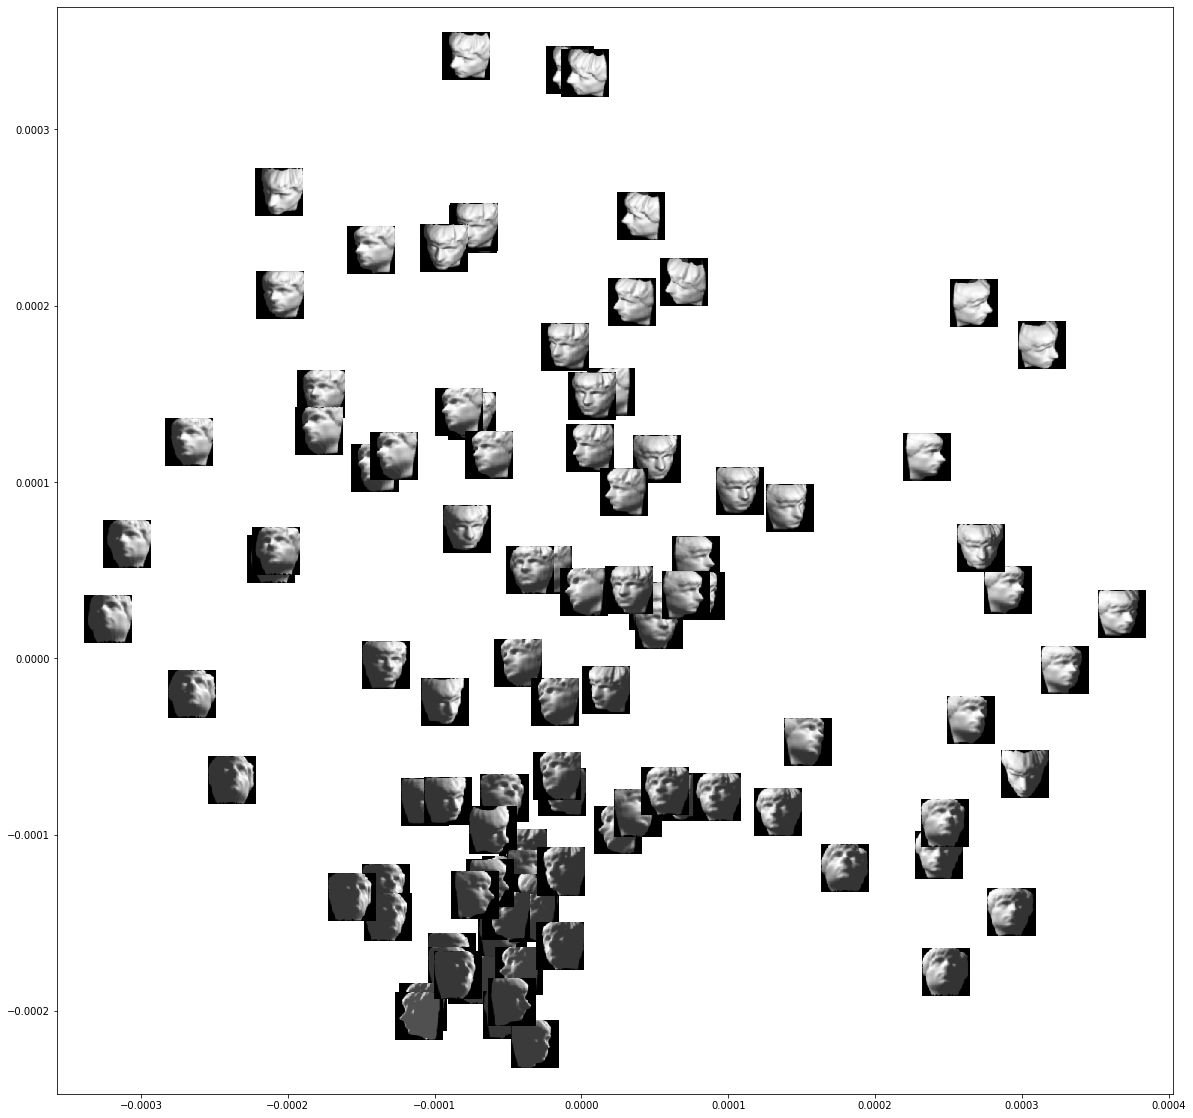

In [49]:
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    
    
    im = OffsetImage(image, zoom=zoom,cmap='gray')
    
    
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots(figsize=(20,20))
rand = random.sample(range(len(images)), 100)

for i in range(len(images)):
    if i in rand:
        x =Z[i,0]
        y =Z[i,1]
        W = images[i].reshape((64,64),order='F')
        imscatter(x,y, W, zoom=0.75, ax=ax)
        ax.plot(x,y)

plt.show()

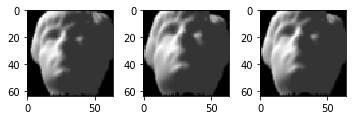

In [50]:
# We pick 3 points that are close
W1 = images[245].reshape((64,64),order='F')
W2 = images[537].reshape((64,64),order='F')
W3 = images[668].reshape((64,64),order='F')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].imshow(W1,cmap='gray')
axes[1].imshow(W2,cmap='gray')
axes[2].imshow(W3,cmap='gray')

fig.tight_layout()